In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
url = '/content/drive/MyDrive/Assignment 2/'

In [ ]:
dataset_C = url + 'Dataset C.zip'
with ZipFile(dataset_C, 'r') as zip:
  zip.extractall()

In [ ]:
PATH = '/content/'
data_labels = pd.read_csv(PATH + 'training-c.csv', usecols = ['filename', 'digit'])
print(data_labels.shape)
data_labels.head()

(24298, 2)


,filename,digit
0,c00000.png,6
1,c00001.png,1
2,c00002.png,3
3,c00003.png,2
4,c00004.png,7


In [ ]:
TRAIN_PATH = url + 'Train'
os.mkdir(TRAIN_PATH)

def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) 

processImages('training-c')

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(data_labels, TRAIN_PATH, train_transform)
test_data = Dataset(data_labels, TRAIN_PATH, test_transform)

print("Trainig Samples: ", len(train_data))

Trainig Samples:  24298


# **Base Parameters**

In [ ]:
batch_size = 90
num_iters = 20000
input_dim = 28*28
num_hidden = 220
output_dim = 10

learning_rate = 0.001

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

100


In [ ]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:216
Test dataloader:54


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 =nn.ReLU()

 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.Softmax(dim=0)
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        # self.linear_5= nn.Linear(num_hidden, num_hidden)
        # self.relu_5=nn.ReLU()

 
        # self.linear_6 = nn.Linear(num_hidden, num_hidden)
        # self.relu_6 =nn.ReLU()

 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        # out  = self.linear_5(out)
        # out = self.relu_5(out)
 
        # out  = self.linear_6(out)
        # out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [ ]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=220, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=220, out_features=220, bias=True)
  (relu_2): Softmax(dim=0)
  (linear_3): Linear(in_features=220, out_features=220, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=220, out_features=220, bias=True)
  (relu_4): ReLU()
  (linear_out): Linear(in_features=220, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Epoch:  2
Epoch:  3
Iteration: 500. Loss: 1.697583556175232. Accuracy: 45.23564519448446
Epoch:  4
Epoch:  5
Iteration: 1000. Loss: 1.1747006177902222. Accuracy: 57.439802428483226
Epoch:  6
Epoch:  7
Iteration: 1500. Loss: 0.9749236106872559. Accuracy: 65.42498456472525
Epoch:  8
Epoch:  9
Epoch:  10
Iteration: 2000. Loss: 0.8627817034721375. Accuracy: 70.32311175138918
Epoch:  11
Epoch:  12
Iteration: 2500. Loss: 0.6644816398620605. Accuracy: 74.74789051245112
Epoch:  13
Epoch:  14
Iteration: 3000. Loss: 0.5630426406860352. Accuracy: 76.20909652191808
Epoch:  15
Epoch:  16
Epoch:  17
Iteration: 3500. Loss: 0.465434730052948. Accuracy: 78.8022226795637
Epoch:  18
Epoch:  19
Iteration: 4000. Loss: 0.4452982544898987. Accuracy: 78.6993208479111
Epoch:  20
Epoch:  21
Iteration: 4500. Loss: 0.5338332056999207. Accuracy: 79.95472319407286
Epoch:  22
Epoch:  23
Epoch:  24
Iteration: 5000. Loss: 0.22365666925907135. Accuracy: 81.00432187692941
Epoch:  25
Epoch:  26
Iteration: 5500.

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Assignment 2/third_attempt.pkl')

[1.697583556175232, 1.1747006177902222, 0.9749236106872559, 0.8627817034721375, 0.6644816398620605, 0.5630426406860352, 0.465434730052948, 0.4452982544898987, 0.5338332056999207, 0.22365666925907135, 0.2542998492717743, 0.37744835019111633, 0.28333988785743713, 0.3014845848083496, 0.21140199899673462, 0.1639271378517151, 0.19389453530311584, 0.22297503054141998, 0.2401999831199646, 0.12950870394706726, 0.09908965229988098, 0.25782549381256104, 0.08993829041719437, 0.18095281720161438, 0.19688688218593597, 0.03158694505691528, 0.09576345980167389, 0.15410113334655762, 0.06466773897409439, 0.027526680380105972, 0.047488804906606674]


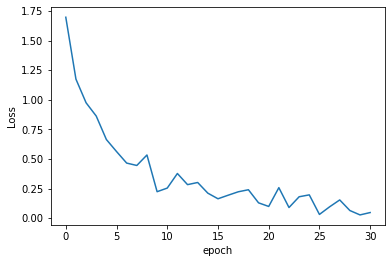

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()